<div style="text-align: right;">
<a target="_blank" href="https://colab.research.google.com/github/hkaragah/hkaragah.github.io/blob/main/structure/moment_curvature/steel_w_sec_moment_curvature.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<div style="font-size: 0.8em; color: #555;">By Hossein Karagah</div>
<div style="font-size: 0.8em; color: #555;">© Copyright 2025 GNU GENERAL PUBLIC LICENSE.</div>
</div>

# Instantenous Center of Rotation Method
__Eccentrically Loaded Bolt Group__

In [1]:
from __future__ import annotations
from dataclasses import dataclass
import os
import sys
sys.path.append(os.path.abspath("../../.."))
from assets.modules.shapes import Point, Vector
from assets.modules.materials import SteelSectionCategories, ASTMSteel
from typing import Protocol, Union, Tuple, Optional, List, Dict
import numpy as np
from math import prod, pi, sqrt

import matplotlib.pyplot as plt
import matplotlib.patches as pch

In [24]:
@dataclass
class Force:
    """Applied force at a point in a 2D bolt group coordinate system.
    """
    pos: Point    # Point of application in the same coordinate system as the bolt group.
    mag: Optional[float] = None   # Magnitude |F| (kips).
    alpha: Optional[float] = None # Angle from +x, radians, CCW positive.
    vec: Optional[Vector] = None  # Force vector (kips).
    
    def __post_init__(self) -> None:
        # You must provide either vec, or (mag and alpha)
        if self.vec is None and (self.mag is None or self.alpha is None):
            raise ValueError(
                "Force requires either 'vec' or both 'mag' and 'alpha'."
            )

        # Case 1: mag/alpha given, vec missing → compute vec
        if self.vec is None:
            Fx = self.mag * np.cos(self.alpha)
            Fy = self.mag * np.sin(self.alpha)
            self.vec = Vector(Fx, Fy)

        # Case 2: vec given, mag/alpha missing → compute them
        if self.mag is None or self.alpha is None:
            mag = self.vec.magnitude
            alpha = float(np.arctan2(self.vec.y, self.vec.x))
            self.mag = mag
            self.alpha = alpha
            
    @property
    def x(self) -> float:
        """X-component of the force (kips)."""
        return self.vec.x
    
    @property
    def y(self) -> float:
        """Y-component of the force (kips)."""
        return self.vec.y
    
    @property
    def F(self) -> Vector:
        """Force vector."""
        return self.vec
    
    def moment_about(self, point: Point) -> Vector:
        """Scalar moment about a point (kips-in) using 2D cross product.

        M = |r x F|, where r is distance vectorfrom 'point' to 'pos'.
        Positive sign convention: out-of-plane z-component.
        """
        r = Vector(self.pos.x - point.x, self.pos.y - point.y)

        return r.cross(self.F)
    
    def normalized_moment_about(self, point: Point) -> Vector:
        """Normalized moment about a point (inches), Mo = M / |F|."""
        if self.mag == 0.0:
            raise ValueError("Force magnitude must be non-zero to compute normalized moment.")
        
        return self.moment_about(point) / self.mag
    
    def __str__(self):
        return (f"Force @ ({self.pos.x:.3f}, {self.pos.y:.3f}): "
                f" Fx={self.x:.3f}, Fy={self.y:.3f} "
                f"({self.mag:.3f} < {np.degrees(self.alpha):.3f}°)")
    
    
@dataclass
class BoltGroup:
    """Collection of bolt coordinates as Point objects."""
    coords: List[Point]
    
    @property
    def n(self) -> int:
        """Number of bolts in the group."""
        return len(self.coords)
    
    @property
    def centroid(self) -> Point:
        """Centroid of the bolt group."""
        if self.n == 0:
            raise ValueError("BoltGroup must contain at least one bolt.")
        
        x_coords = np.array([bolt.x for bolt in self.coords], dtype=float)
        y_coords = np.array([bolt.y for bolt in self.coords], dtype=float)
        xo = x_coords.mean()
        yo = y_coords.mean()
        
        return Point(xo, yo)
    
    def distance_to(self, point: Point) -> np.ndarray: 
        """Distances from all bolts to a given point."""
        return np.array([bolt.distance_to(point) for bolt in self.coords], dtype=float)
    
    def position_to(self, point: Point) -> List[Vector]: 
        """Position vectors from all bolts to a given point."""
        return [bolt.position(point) for bolt in self.coords]
    
    def dx_to(self, point: Point) -> np.ndarray:
        """X-distances from all bolts to a given point."""
        return np.array([bolt.x - point.x for bolt in self.coords], dtype=float)
    
    def dy_to(self, point: Point) -> np.ndarray:
        """Y-distances from all bolts to a given point."""
        return np.array([bolt.y - point.y for bolt in self.coords], dtype=float)

    def J(self, point: Point) -> float:
        """Polar moment of inertia of the bolt group about a point."""
        d = self.distance_to(point)
        return float(np.sum(d**2))

    @property
    def Jo(self) -> float:
        """Polar moment of inertia about the centroid."""
        return self.J(self.centroid)


@dataclass
class BoltGroupElasticState:
    """Shared quantities for elastic bolt-group calculations."""
    ic: Point              # instantaneous center of rotation
    distances: np.ndarray  # distances from each bolt to IC
    sum_d2: float          # Σ r_i^2
    Mo: float              # normalized moment about centroid
    
    def __str__(self):
        ic_str = f"({self.ic.x:.3f}, {self.ic.y:.3f})"
        distances_str = "[" + ", ".join(f"{d:.3f}" for d in self.distances) + "]"

        return (f"Bolt Group Elastic State:\n"  
                f"  ic={ic_str}\n"  
                f"  distances={distances_str}\n"
                f"  sum_d2={self.sum_d2:.3f}\n"  
                f"  Mo={self.Mo:.3f}\n")


def bolt_group_elastic_instantenous_center(bolts: BoltGroup, force: Force) -> Point:
    """Calculate the elastic instantaneous center of rotation (IC) for a bolt group.

    Args:
        bolts (BoltGroup): BoltGroup object containing bolt coordinates.
        force (Force): Applied force as a Force object.

    Returns:
        Point: Elastic instantaneous center (IC) of rotation as a Point object.
    """  
    Mo = force.normalized_moment_about(bolts.centroid).z
    if Mo == 0.0:
        raise ValueError("Normalized moment Mo is zero; IC is undefined.")

    c = bolts.centroid
    
    # Coordinates of elastic IC relative to centroid
    ax = -(force.y / bolts.n) * (bolts.Jo / Mo)
    ay = (force.x / bolts.n) * (bolts.Jo / Mo)

    return Point(c.x + ax, c.y + ay)


def compute_bolt_group_elastic_state(bolts: BoltGroup, force: Force) -> BoltGroupElasticState:
    """Compute shared quantities for elastic bolt-group calculations.

    Args:
        bolts (BoltGroup): BoltGroup object containing bolt coordinates.
        force (Force): Applied force as a Force object.

    Returns:
        BoltGroupElasticState: Object containing shared quantities.
    """ 
    if bolts.n == 0:
        raise ValueError("BoltGroup must contain at least one bolt.")
    if force.mag == 0.0:
        raise ValueError("Force magnitude must be non-zero.")
    
    ic = bolt_group_elastic_instantenous_center(bolts, force)  
    distances = bolts.distance_to(ic)
    sum_d2 = np.sum(distances**2)
    if sum_d2 == 0.0:
        raise ValueError("All bolts are at the instantaneous center; invalid configuration.")

    # Normalized moment about bolt group centroid
    Mo = force.normalized_moment_about(bolts.centroid).z
        
    return BoltGroupElasticState(ic=ic, distances=distances, sum_d2=sum_d2, Mo=Mo)


def bolt_group_elastic_coeff(bolts: BoltGroup, force: Force) -> float:
    """Calculate the elastic stiffness coefficient (Ce) of a bolt group about the instantaneous center of rotation (IC).

    Args:
        bolts (BoltGroup): BoltGroup object containing bolt coordinates.
        force (Force): Applied force as a Force object.

    Returns:
        float: Elastic solution for bolt coefficient, Ce.
    """ 
    state = compute_bolt_group_elastic_state(bolts, force)
    
    # Moment about IC of normalized applied force  
    Mp = force.normalized_moment_about(state.ic).z
    
    d_max = float(state.distances.max())
    if Mp == 0.0 or d_max == 0.0:
        raise ValueError("Mp or maximum distance is zero; cannot compute elastic coefficient (Ce).")
    
    return -state.sum_d2 / (Mp * d_max)


def bolt_group_deformations(bolts: BoltGroup, ic: Point) -> np.ndarray:
    """Calculate the deformations of each bolt in the bolt group based on its distance to the instantaneous center of rotation (IC). Maximum allowable deformation is limited by AISC 360-22, Part 7.

    Args:
        bolts (BoltGroup): BoltGroup object containing bolt coordinates.
        ic (Point): Instantaneous center of rotation as a Point object.

    Returns:
        np.ndarray: Array of deformations for each bolt in the bolt group (inches).
    """   
    # Disntaces from bolts to IC
    d = bolts.distance_to(ic)
    if d.size == 0:
        raise ValueError("BoltGroup must contain at least one bolt.")
    
    if d.max() == 0.0:
        # All bolts at IC → zero deformation
        return np.zeros_like(d)
    
    # Maximum allowable bolt deformation per AISC 360-22, Part 7
    D_max = 0.34 # inches
    
    return D_max * (d / d.max())


def bolt_group_elastic_forces(bolts: BoltGroup, force: Force) -> List[Force]:
    """Calculate the elastic forces (Fe) in each bolt of the bolt group based on the elastic instantaneous center of rotation (IC).

    Args:
        bolts (BoltGroup): BoltGroup object containing bolt coordinates.
        force (Force): Applied force as a Force object.

    Returns:
        np.ndarray: Array of elastic forces (Fe) in each bolt of the bolt group (kips).
    """   
    state = compute_bolt_group_elastic_state(bolts, force)
    
    # Moment about IC of normalized applied force  
    Mp = force.normalized_moment_about(state.ic).z
    
    dx = bolts.dx_to(state.ic)
    dy = bolts.dy_to(state.ic)
    
    # Elastic forces in each bolt
    fx = force.mag * (dy / state.sum_d2) * Mp
    fy = -force.mag * (dx / state.sum_d2) * Mp
    
    F = []
    for i, coord in enumerate(bolts.coords):
        F.append(Force(pos=coord, vec=Vector(fx[i], fy[i])))
    
    return F


def bolt_nominal_shear_strength_ratio(delta: float | np.ndarray) -> float:
    """Calculate the nominal shear strength ratio (R/Rult) of a single bolt or bolt group based on deformation.
    
    R/Rult = (1 - e^(-10Δ))^0.55

    Args:
        delta (float | np.ndarray): Total deformation, including shear, bearing, and bending deformation in the bolt and bearing deformation of the connection elements (inches).

    Returns:
        float: Nominal shear strength ratio (R/Rultof the single bolt or bolt group (unitless).
    """   
    if np.isscalar(delta):
        delta = np.array([float(delta)], dtype=float)
    else:
        delta = np.asarray(delta, dtype=float)
    
    return np.power(1 - np.exp(-10 * delta), 0.55)
    
    
def bolt_group_nominal_flexural_strength(bolts: BoltGroup, ic: Point) -> np.ndarray:
    """Calculate sum of the nominal flexural strength (ΣMi) of the bolt group relative to the instantaneous center of rotation (IC).
    
    ΣMi = Σ (Ri/Rult) * di
    
    Args:
        bolts (BoltGroup): BoltGroup object containing bolt coordinates.
        ic (Point): Instantaneous center of rotation as a Point object.
        
    Returns:
        np.ndarray: Array of nominal flexural strengths (Mi) for each bolt in the bolt group (kips-in).
    
    """
    d = bolts.distance_to(ic)
    delta = bolt_group_deformations(bolts, ic)
    R_ratio = bolt_nominal_shear_strength_ratio(delta) # R/Rult
    
    return np.dot(R_ratio, d)


def bolt_group_ultimate_coeff(bolts: BoltGroup, force: Force, ic: Point) -> float:
    """
    Calculate the ultimate coefficient (Cu) of the bolt group based on instantaneous center of rotation (IC).
    
    Args:
        bolts (BoltGroup): BoltGroup object containing bolt coordinates.
        force (Force): Applied force as a Force object.
        ic (Point): Instantaneous center of rotation as a Point object.
        
    Returns:
        float: Ultimate coefficient (Cu) of the bolt group (unitless).
    """
    # Moment about IC of normalized applied force  
    Mp = force.normalized_moment_about(ic).z
    
    # Sum of nominal flexural strengths of the bolt group relative to IC
    sum_Mi = bolt_group_nominal_flexural_strength(bolts, ic)
    
    return -sum_Mi / Mp


def bolt_group_ultimate_forces(bolts: BoltGroup, force:Force, ic: Point) -> np.ndarray:
    """Calculate the ultimate forces (Fu) in each bolt of the bolt group based on instantaneous center of rotation (IC).

    Args:
        bolts (BoltGroup): Bolt coordinates.
        force (Force): Applied force.
        ic (Point): Instantaneous center of rotation.

    Returns:
        np.ndarray: Array of ultimate forces (Fu) in each bolt of the bolt group (kips).
    """   
    d = bolts.distance_to(ic)
    dx = bolts.dx_to(ic)
    dy = bolts.dy_to(ic)
    
    delta = bolt_group_deformations(bolts, ic)
    R_ratio = bolt_nominal_shear_strength_ratio(delta) # R/Rult
    
    Mp = force.normalized_moment_about(ic).z
    sum_Mi = bolt_group_nominal_flexural_strength(bolts, ic)
    R_ult = -Mp / sum_Mi
    
    # Ultimate forces in each bolt
    fx = -R_ult * R_ratio * (dy / d)
    fy = R_ult * R_ratio * (dx / d)
    
    F = []
    for i, coord in enumerate(bolts.coords):
        F.append(Force(pos=coord, vec=Vector(fx[i], fy[i])))
    
    return F


def bolt_group_force_equilibrium(bolts: BoltGroup, force: Force, ic: Point) -> Tuple[float, float]:
    """Calculate the bolt forces in equilibrium with the applied force for a bolt group.

    Args:
        bolts (BoltGroup): Bolt coordinates.
        force (Force): Applied force.
        ic (Point): Instantaneous center of rotation.
        R_ult (float): Ultimate shear strength of a single bolt (kips).

    Returns:
        Tuple[float, float]: Tuple containing the sum of bolt forces and applied force in the x and y directions (kips).
    """
    F = bolt_group_ultimate_forces(bolts, force, ic)
    Fxx = np.array([Fi.x for Fi in F], dtype=float).sum() + force.x
    Fyy = np.array([Fi.y for Fi in F], dtype=float).sum() + force.y
    
    return Fxx, Fyy


def find_bolt_group_equilibrium_ic(bolts: BoltGroup, force: Force, **kwargs) -> Point:
    """Find the instantaneous center of rotation (IC) for bolt group force equilibrium using the Newton-Raphson method.

    Args:
        bolts (BoltGroup): Bolt coordinates.
        force (Force): Applied force.
        R_ult (float): Ultimate shear strength of a single bolt (kips).
        ic_initial (Point): Initial guess for the IC.
        tol (float, optional): Tolerance for convergence. Defaults to 1e-6.
        max_iter (int, optional): Maximum number of iterations. Defaults to 100.

    Returns:
        Point: Instantaneous center of rotation (IC) in equilibrium.
    """
    max_iter = kwargs.get('max_iter', 100)
    tol = kwargs.get('tol', 1e-6)
    method = kwargs.get('method', 'brandt')  # 'brandt' or 'newton'
    
    state = compute_bolt_group_elastic_state(bolts, force)
    
    J = bolts.Jo
    n = bolts.n
    Mo = state.Mo
    
    # Initial guess for IC is the elastic IC
    ic = state.ic


    for i in range(max_iter):
        Fxx, Fyy = bolt_group_force_equilibrium(bolts, force, ic)
        
        # Check convergence
        if abs(Fxx) < tol and abs(Fyy) < tol:
            return ic
        
        if method == 'brandt':
            # Brandt (1982) method ------
            ic = Point(ic.x - Fyy * J / (n * Mo), ic.y + Fxx * J / (n * Mo))

        else:
            # Numerical Jacobian --------
            h = 1e-8
            Fxx_dx_plus, Fyy_dx_plus = bolt_group_force_equilibrium(bolts, force, Point(ic.x + h, ic.y))
            Fxx_dy_plus, Fyy_dy_plus = bolt_group_force_equilibrium(bolts, force, Point(ic.x, ic.y + h))
            
            J = np.array([[ (Fxx_dx_plus - Fxx) / h, (Fxx_dy_plus - Fxx) / h ],
                        [ (Fyy_dx_plus - Fyy) / h, (Fyy_dy_plus - Fyy) / h ]], dtype=float)
            
            # Update IC using Newton-Raphson step
            try:
                delta_ic = np.linalg.solve(J, -np.array([Fxx, Fyy], dtype=float))
            except np.linalg.LinAlgError:
                raise ValueError("Jacobian is singular; cannot proceed with Newton-Raphson iteration.")
            
            ic = Point(ic.x + delta_ic[0], ic.y + delta_ic[1])
    
    raise ValueError("Maximum iterations reached without convergence.")


    


    
    

## Example 1

In [74]:
# Exlastic Coefficient (Ce)
bolts = BoltGroup(coords=[Point(0,3), Point(0,0), Point(0,-3)])
force = Force(mag=1, alpha=np.radians(-90), pos=Point(4,0))

state = compute_bolt_group_elastic_state(bolts, force)
print(state)


Ce = bolt_group_elastic_coeff(bolts, force)
print(f"Ce: {Ce:.3f}")

deformations = bolt_group_deformations(bolts, state.ic)
print("Bolt Deformations (in):", deformations)

f_e = bolt_group_elastic_forces(bolts, force)
for i in range(bolts.n):
    print(f_e[i])



Bolt Group Elastic State:
  ic=(-1.500, -0.000)
  distances=[3.354, 1.500, 3.354]
  sum_d2=24.750
  Mo=-4.000

Ce: 1.342
Bolt Deformations (in): [0.34       0.15205262 0.34      ]
Force @ (0.000, 3.000):  Fx=-0.667, Fy=0.333 (0.745 < 153.435°)
Force @ (0.000, 0.000):  Fx=-0.000, Fy=0.333 (0.333 < 90.000°)
Force @ (0.000, -3.000):  Fx=0.667, Fy=0.333 (0.745 < 26.565°)


In [75]:
# Ultimate Coefficient (Cu)

bolt_dia = 0.7 # inches
bolt_area = pi * (bolt_dia / 2)**2 # in²
bolt_fu = 0.7 * 120 # ksi
R_ult = bolt_area * bolt_fu # kips, single shear
print(f"Rult: {R_ult:.3f} kips")

ic = find_bolt_group_equilibrium_ic(bolts, force, method='brandt')
print(f"Equilibrium IC: ({ic.x:.3f}, {ic.y:.3f})")

Cu = bolt_group_ultimate_coeff(bolts, force, ic)
print(f"Cu: {Cu:.3f}")

Fxx, Fyy = bolt_group_force_equilibrium(bolts, force, ic)
print(f"Force Equilibrium: Fxx={Fxx:.6f}, Fyy={Fyy:.6f}")

f_u = bolt_group_ultimate_forces(bolts, force, ic)
for i in range(bolts.n):
    print(f_u[i])
    
    

Rult: 32.327 kips
Equilibrium IC: (-0.979, -0.000)
Cu: 1.400
Force Equilibrium: Fxx=0.000000, Fyy=0.000000
Force @ (0.000, 3.000):  Fx=-0.667, Fy=0.218 (0.701 < 161.919°)
Force @ (0.000, 0.000):  Fx=-0.000, Fy=0.565 (0.565 < 90.000°)
Force @ (0.000, -3.000):  Fx=0.667, Fy=0.218 (0.701 < 18.081°)


In [76]:
# Utility functions for plotting
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.axes import Axes

def plot_bolt_group(ax: Axes, bolts: BoltGroup, *, color="black", size=40, zorder=3):
    """Plot bolt locations on the given Axes."""
    bx: list[float] = [b.x for b in bolts.coords]
    by = [b.y for b in bolts.coords]
    ax.scatter(bx, by, facecolor='none', edgecolor=color, s=size, zorder=zorder)
    
    
def draw_arrow(ax: Axes, x0, y0, dx, dy, *, color="red", lw=1, scale=1.0,
               head_size=10, zorder=4):
    """Draw a clean arrow from (x0,y0) to (x0+dx*scale, y0+dy*scale)."""
    arrow = FancyArrowPatch(
        (x0, y0),
        (x0 + dx * scale, y0 + dy * scale),
        arrowstyle='-|>',
        linewidth=lw,
        color=color,
        mutation_scale=head_size,
        zorder=zorder
    )
    ax.add_patch(arrow)
    return (x0 + dx * scale, y0 + dy * scale)  # tip point


def force_scale(forces: List[Force], target_len=1.5):
    mags = np.array([float(f.mag) for f in forces], dtype=float)
    mmax = mags.max() if mags.size else 1.0
    return target_len / (mmax if mmax > 0 else 1.0)


def label_force(ax: Axes, x, y, text, *, dx=0.1, dy=0.1, color="red", fontsize=9, zorder=6):
    ax.text(x + dx, y + dy, text, color=color, fontsize=fontsize,
            ha="left", va="bottom", zorder=zorder)


def set_equal_limits(axes: List[Axes], bolts: BoltGroup, force: Force, ic: List[Point], pad=1.0):
    bx: list[float] = [b.x for b in bolts.coords]
    by = [b.y for b in bolts.coords]
    
    xmin = min(bx + [force.pos.x] + [p.x for p in ic]) - pad
    xmax = max(bx + [force.pos.x] + [p.x for p in ic]) + pad
    ymin = min(by + [force.pos.y] + [p.y for p in ic]) - pad
    ymax = max(by + [force.pos.y] + [p.y for p in ic]) + pad

    cx, cy = (xmin + xmax) / 2, (ymin + ymax) / 2
    half = max((xmax - xmin), (ymax - ymin)) / 2 + pad
    
    for ax in axes:
        ax.set_xlim(cx - half, cx + half)
        ax.set_ylim(cy - half, cy + half)
        ax.set_aspect("equal", adjustable="box")
        ax.grid(True, alpha=0.25)


def plot_applied_force(ax: Axes, force: Force, show_text=False, *, scale, head_size=14, lw = 1.0, color="black"):
    tipx, tipy = draw_arrow(ax, force.pos.x, force.pos.y, force.x, force.y,
                            color=color, lw=lw, scale=scale, head_size=head_size)
    
    if show_text:
        label_force(ax, tipx, tipy, f"P = {force.mag:.2f} k", color=color)


def plot_bolt_forces(ax: Axes, forces: List[Force], show_text=False, *, scale, head_size=14, color="red",
                     label_mode="mag", label_at="tip"):
    """
    label_mode:
      - "mag"  -> |F|
      - "xy"   -> (Fx, Fy)
      - "all"  -> |F| + (Fx, Fy)
    label_at:
      - "tip"  -> label near arrow tip
      - "bolt" -> label near bolt point
    """
    # ncrease target_len to make arrows bigger
    f_scaled = force_scale(forces, target_len=scale)
    
    for f in forces:
        tipx, tipy = draw_arrow(ax, f.pos.x, f.pos.y, f.x, f.y,
                                color=color, lw=1.0, scale=f_scaled, head_size=head_size)
        
        if label_mode == "mag":
            txt = f"{f.mag:.2f} k"
        elif label_mode == "xy":
            txt = f"({f.x:.2f}, {f.y:.2f})"
        elif label_mode == "all":
            txt = f"{f.mag:.2f} k\n({f.x:.2f}, {f.y:.2f})"
        else:
            raise ValueError("label_mode must be 'mag', 'xy', or 'all'.")

        if show_text:
            if label_at == "tip":
                label_force(ax, tipx, tipy, txt, color=color)
            elif label_at == "bolt":
                label_force(ax, f.pos.x, f.pos.y, txt, color=color)
            else:
                raise ValueError("label_at must be 'tip' or 'bolt'.")
        
        
def plot_ic(ax: Axes, ic: Point, *, color="red", size=140, zorder=5):
    ax.scatter(ic.x, ic.y, color=color, marker="+", s=size, zorder=zorder)
    ax.annotate("IC", xy=(ic.x, ic.y), xytext=(0, 10), textcoords="offset points",
                 ha="center", color=color)

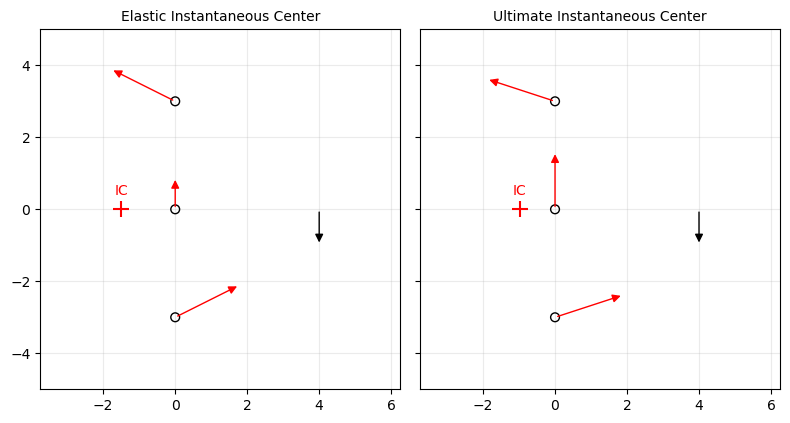

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6), sharey=True)

# sizes, scales and offsets
HEAD_SIZE = 12
APPLIED_LOAD_SCALE = 1.0
BOLT_LOAD_SCALE = 2.0
AXIS_LIMIT_PAD = 1.0

# ---- Elastic ----
ax[0].set_title("Elastic Instantaneous Center", fontsize=10)
plot_bolt_group(ax[0], bolts)
plot_applied_force(ax[0], force, scale=APPLIED_LOAD_SCALE, head_size=HEAD_SIZE)
plot_bolt_forces(ax[0], f_e, scale=BOLT_LOAD_SCALE, head_size=HEAD_SIZE)
plot_ic(ax[0], state.ic)

# ---- Ultimate ----
ax[1].set_title("Ultimate Instantaneous Center", fontsize=10)
plot_bolt_group(ax[1], bolts)
plot_applied_force(ax[1], force, scale=APPLIED_LOAD_SCALE, head_size=HEAD_SIZE)
plot_bolt_forces(ax[1], f_u, scale=BOLT_LOAD_SCALE, head_size=HEAD_SIZE)
plot_ic(ax[1], ic)

set_equal_limits(ax, bolts, force, [state.ic, ic], pad=AXIS_LIMIT_PAD)
plt.tight_layout()
plt.show()


## Example 2

In [78]:
# Exlastic Coefficient (Ce)
bolts = BoltGroup(coords=[
    Point(-3,-3), Point(-3,0), Point(-3,3), Point(3,-3), Point(3,0), Point(3,3)
    ])
print(f"Jo = {bolts.Jo:.3f} in⁴")

force = Force(pos=Point(20,5), vec=Vector(0.6, -0.8))

state = compute_bolt_group_elastic_state(bolts, force)
print(state)


Ce = bolt_group_elastic_coeff(bolts, force)
print(f"Ce: {Ce:.3f}")

deformations = bolt_group_deformations(bolts, state.ic)
print("Bolt Deformations (in):", deformations)

f_e = bolt_group_elastic_forces(bolts, force)
for i in range(bolts.n):
    print(f_e[i])



Jo = 90.000 in⁴
Bolt Group Elastic State:
  ic=(-0.632, -0.474)
  distances=[3.463, 2.415, 4.204, 4.424, 3.662, 5.025]
  sum_d2=93.740
  Mo=-19.000

Ce: 0.943
Bolt Deformations (in): [0.23428621 0.16341131 0.28444435 0.29930159 0.24777948 0.34      ]
Force @ (-3.000, -3.000):  Fx=0.533, Fy=-0.500 (0.731 < -43.152°)
Force @ (-3.000, 0.000):  Fx=-0.100, Fy=-0.500 (0.510 < -101.310°)
Force @ (-3.000, 3.000):  Fx=-0.733, Fy=-0.500 (0.888 < -145.713°)
Force @ (3.000, -3.000):  Fx=0.533, Fy=0.767 (0.934 < 55.176°)
Force @ (3.000, 0.000):  Fx=-0.100, Fy=0.767 (0.773 < 97.431°)
Force @ (3.000, 3.000):  Fx=-0.733, Fy=0.767 (1.061 < 133.727°)


In [79]:
# Ultimate Coefficient (Cu)

bolt_dia = 0.7 # inches
bolt_area = pi * (bolt_dia / 2)**2 # in²
bolt_fu = 0.7 * 120 # ksi
R_ult = bolt_area * bolt_fu # kips, single shear
print(f"Rult: {R_ult:.3f} kips")

ic = find_bolt_group_equilibrium_ic(bolts, force, method='brandt')
print(f"Equilibrium IC: ({ic.x:.3f}, {ic.y:.3f})")

Cu = bolt_group_ultimate_coeff(bolts, force, ic)
print(f"Cu: {Cu:.3f}")

Fxx, Fyy = bolt_group_force_equilibrium(bolts, force, ic)
print(f"Force Equilibrium: Fxx={Fxx:.6f}, Fyy={Fyy:.6f}")

f_u = bolt_group_ultimate_forces(bolts, force, ic)
for i in range(bolts.n):
    print(f_u[i])
    
    

Rult: 32.327 kips
Equilibrium IC: (-1.308, -0.582)
Cu: 1.095
Force Equilibrium: Fxx=-0.000000, Fyy=-0.000001
Force @ (-3.000, -3.000):  Fx=0.677, Fy=-0.474 (0.826 < -34.986°)
Force @ (-3.000, 0.000):  Fx=-0.237, Fy=-0.689 (0.728 < -108.988°)
Force @ (-3.000, 3.000):  Fx=-0.784, Fy=-0.370 (0.867 < -154.716°)
Force @ (3.000, -3.000):  Fx=0.435, Fy=0.774 (0.888 < 60.697°)
Force @ (3.000, 0.000):  Fx=-0.117, Fy=0.869 (0.877 < 97.697°)
Force @ (3.000, 3.000):  Fx=-0.573, Fy=0.689 (0.896 < 129.745°)


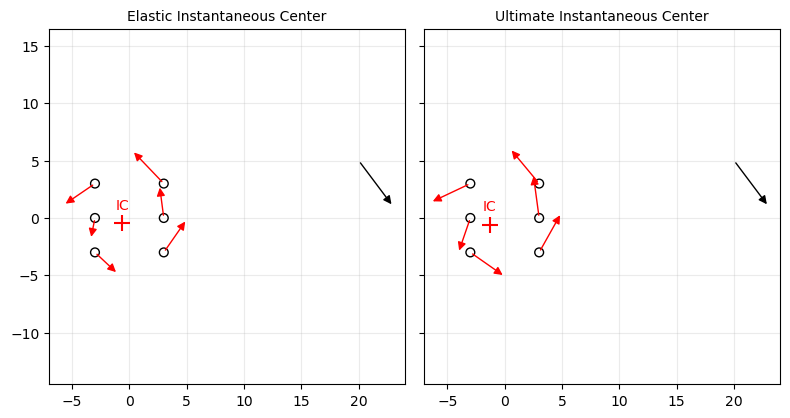

In [86]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6), sharey=True)

# sizes, scales and offsets
HEAD_SIZE = 12
APPLIED_LOAD_SCALE = 5.0
BOLT_LOAD_SCALE = 4.0
AXIS_LIMIT_PAD = 2.0

# ---- Elastic ----
ax[0].set_title("Elastic Instantaneous Center", fontsize=10)
plot_bolt_group(ax[0], bolts)
plot_applied_force(ax[0], force, scale=APPLIED_LOAD_SCALE, head_size=HEAD_SIZE)
plot_bolt_forces(ax[0], f_e, scale=BOLT_LOAD_SCALE, head_size=HEAD_SIZE)
plot_ic(ax[0], state.ic)

# ---- Ultimate ----
ax[1].set_title("Ultimate Instantaneous Center", fontsize=10)
plot_bolt_group(ax[1], bolts)
plot_applied_force(ax[1], force, scale=APPLIED_LOAD_SCALE, head_size=HEAD_SIZE)
plot_bolt_forces(ax[1], f_u, scale=BOLT_LOAD_SCALE, head_size=HEAD_SIZE)
plot_ic(ax[1], ic)

set_equal_limits(ax, bolts, force, [state.ic, ic], pad=AXIS_LIMIT_PAD)
plt.tight_layout()
plt.show()

## References:

1. AISC 360, "Steel Construction Manual", Part 7, AISC, 2022.
2. Salmon, C.G., Johnson, J.E., Malhas, F.A., "Steel Structures Design and Behavior", 5th Edition, p.117-124, 2009.
3. Brandt, G.D., "Rapid Determination of Ultimate Strength of Eccentrically Loaded Bolt Group", AISC Engineering Journal: Vol. 19 No. 2: Second Quarter, 1982.